# Data Simulation

In this notebook data is simulated based on Nuc/Cyt model and veloVI is fitted on this data.
The goal is to investigate how the noise level effects the rate parameter inference and its time assignments

**Requires:**
To be able to run the notebook
- the nuc/cyt model in scvelo/inference/* and
- datasets/_simulate and
- core/_models needs to be implemented

**Output:**
-  Rate parameter ratio plots,
-  Phase portrait plots
-  Comparison plots

## Library imports

In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import sys

import mplscience

import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr, ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns

from scvelo.core import NucCytModel
from scvelo.datasets import Simulator
from scvelo.inference import fit_velovi

sys.path.append("../..")
from paths import FIG_DIR  # isort: skip  # noqa: E402

## Function definitions

In [22]:
def _add_significance(ax, left: int, right: int, significance: str, level: int = 0, **kwargs):
    bracket_level = kwargs.pop("bracket_level", 1)
    bracket_height = kwargs.pop("bracket_height", 0.02)
    text_height = kwargs.pop("text_height", 0.01)

    bottom, top = ax.get_ylim()
    y_axis_range = top - bottom

    bracket_level = (y_axis_range * 0.07 * level) + top * bracket_level
    bracket_height = bracket_level - (y_axis_range * bracket_height)

    ax.plot([left, left, right, right], [bracket_height, bracket_level, bracket_level, bracket_height], **kwargs)

    ax.text(
        (left + right) * 0.5,
        bracket_level + (y_axis_range * text_height),
        significance,
        ha="center",
        va="bottom",
        c="k",
    )

In [23]:
def _get_significance(pvalue):
    if pvalue < 0.001:
        return "***"
    elif pvalue < 0.01:
        return "**"
    elif pvalue < 0.1:
        return "*"
    else:
        return "n.s."

## General Settings

In [3]:
SAVE_FIGURES = True
n_obs = 10000
n_vars = 1000
t_max = 20
noise_levels = [0.1, 0.3, 0.5, 0.7, 1, 1.25]

## Definition of parameters for log-normal distribution of kinetic parameters

In [4]:
# define mean and covariance matrix for rate parameters alpha, beta, nu, gamma
mu = np.array([2, 1, 0.5, 0.1])

R = np.array([[1.0, 0.8, 0.5, 0.2], [0.8, 1.0, 0.8, 0.5], [0.5, 0.8, 1.0, 0.8], [0.2, 0.5, 0.8, 1]])

C = np.array([0.4, 0.4, 0.4, 0.4])[:, None]

cov = C.dot(C.T) * R


alpha, beta, nu, gamma = np.exp(np.random.multivariate_normal(mu, cov, size=n_vars).T)  # multivariate log-normal

# remove outliers
idx = (
    (alpha < np.percentile(alpha, 99))
    & (beta < np.percentile(beta, 99))
    & (gamma < np.percentile(gamma, 99))
    & (nu < np.percentile(nu, 99))
)
alpha = alpha[idx]
beta = beta[idx]
nu = nu[idx]
gamma = gamma[idx]

n_vars = np.sum(idx)

## Data Simulator

In [5]:
# Define switches s.t. switching_times are then in [0.1*t_max, 0.5*t_max]
switches = np.random.uniform(0.1, 0.5, size=n_vars)
simulators = []
for noise_level in noise_levels:
    simulators.append(
        Simulator(
            cell_gene_time=False,
            n_obs=n_obs,
            n_vars=n_vars,
            t_final=t_max,
            switches=switches,
            time_distribution="uniform",
            noise_level=noise_level,
        )
    )

## Fit veloVI Model for different noise levels

In [6]:
adatas = []
vaes = []

for simulator in simulators:
    adata = simulator.fit(
        NucCytModel,
        layer_names=["unspliced_nucleus", "spliced_nucleus", "spliced_cytosol"],
        transcription_rate=alpha,
        nuc_export_rate=nu,
        splicing_rate=beta,
        degradation_rate=gamma,
        transcription_rate_=0,
        initial_state=[0, 0, 0],
    )

    vae, adata = fit_velovi(
        adata,
        max_epochs=750,
        unspliced_layer_nuc="unspliced_nucleus",
        spliced_layer_nuc="spliced_nucleus",
        spliced_layer_cyt="spliced_cytosol",
        lr=5e-3,
    )

    vaes.append(vae)
    adatas.append(adata)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 426/750:  57%|██▎ | 426/750 [11:20<08:37,  1.60s/it, v_num=1, train_loss_step=-2.95e+3, train_loss_epoch=-3.26e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -3370.458. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 326/750:  43%|█▋  | 326/750 [08:42<11:19,  1.60s/it, v_num=1, train_loss_step=-1.49e+3, train_loss_epoch=-1.93e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2047.782. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 461/750:  61%|█████▌   | 461/750 [12:08<07:36,  1.58s/it, v_num=1, train_loss_step=-642, train_loss_epoch=-1.1e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1296.766. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 456/750:  61%|███████▎    | 456/750 [12:06<07:48,  1.59s/it, v_num=1, train_loss_step=-505, train_loss_epoch=-514]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -583.233. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 475/750:  63%|████████▊     | 475/750 [12:42<07:21,  1.61s/it, v_num=1, train_loss_step=524, train_loss_epoch=196]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 16.937. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 261/750:  35%|███▍      | 261/750 [06:58<13:04,  1.60s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=797]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 733.758. Signaling Trainer to stop.


## Plot elbo losses

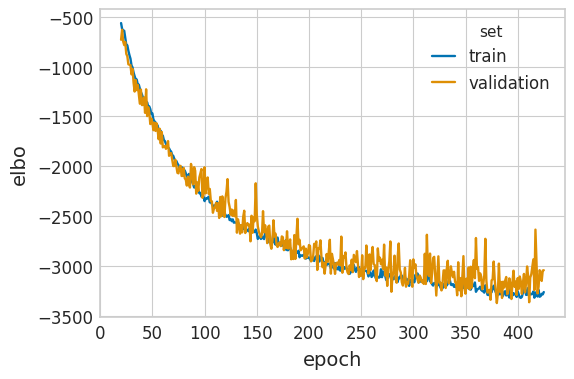

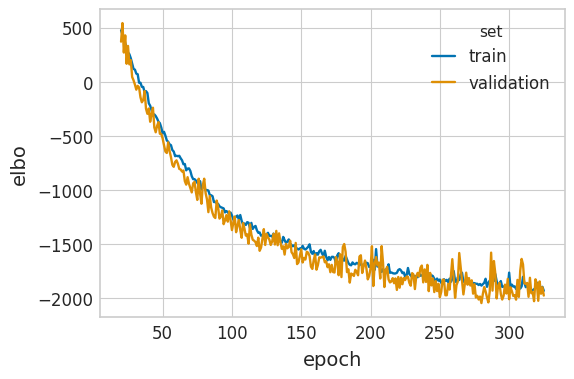

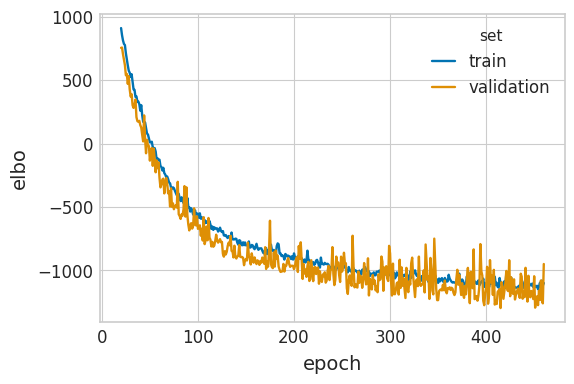

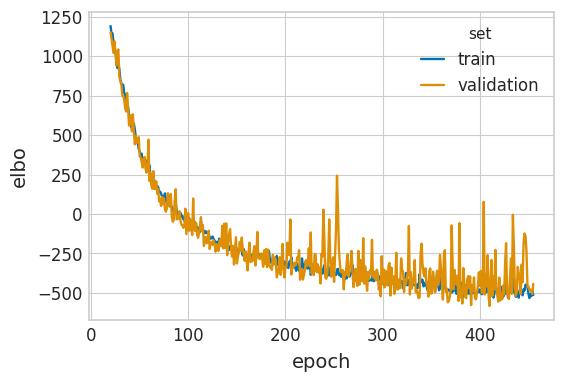

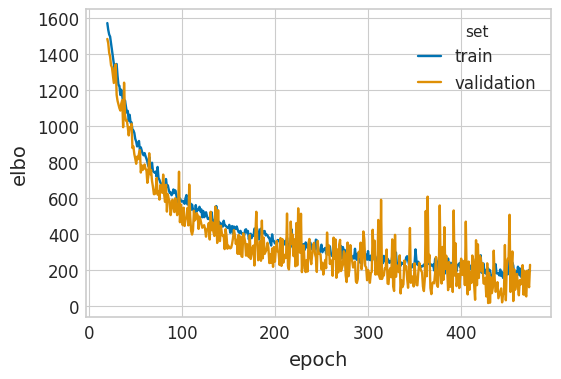

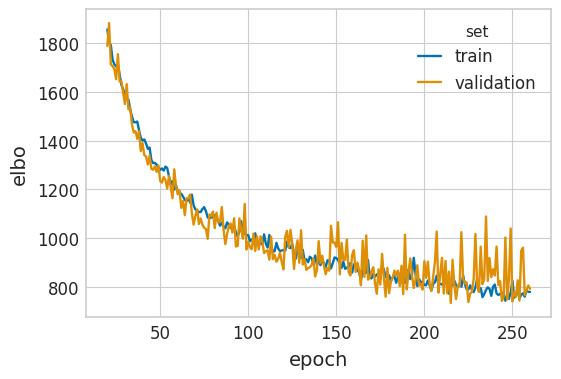

In [7]:
for vae in vaes:
    df = vae.history["elbo_train"].iloc[20:].reset_index().rename(columns={"elbo_train": "elbo"})
    df["set"] = "train"

    _df = vae.history["elbo_validation"].iloc[20:].reset_index().rename(columns={"elbo_validation": "elbo"})
    _df["set"] = "validation"

    df = pd.concat([df, _df], axis=0).reset_index(drop=True)

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.lineplot(data=df, x="epoch", y="elbo", hue="set", palette=["#0173B2", "#DE8F05"], ax=ax)
        plt.show()

## Define true and inferred kinetic ratios for all noise levels

In [17]:
for adata in adatas:
    adata.var["vi_ratio_gamma_beta"] = adata.var["fit_gamma"] / adata.var["fit_beta"]
    adata.var["true_ratio_gamma_beta"] = np.array(adata.var.true_degradation_rate / adata.var.true_splicing_rate)

    # steady state ratio
    adata.var["vi_ratio_gamma_nu"] = adata.var["fit_gamma"] / adata.var["fit_nu"]
    adata.var["true_ratio_gamma_nu"] = np.array(adata.var.true_degradation_rate / adata.var.true_nuc_export_rate)

    adata.var["vi_ratio_alpha_beta"] = adata.var["fit_alpha"] / adata.var["fit_beta"]
    adata.var["true_ratio_alpha_beta"] = np.array(adata.var.true_transcription_rate / adata.var.true_splicing_rate)

    adata.var["vi_ratio_nu_beta"] = adata.var["fit_nu"] / adata.var["fit_beta"]
    adata.var["true_ratio_nu_beta"] = np.array(adata.var.true_nuc_export_rate / adata.var.true_splicing_rate)

    adata.var["vi_ratio_alpha_nu"] = adata.var["fit_alpha"] / adata.var["fit_nu"]
    adata.var["true_ratio_alpha_nu"] = np.array(adata.var.true_transcription_rate / adata.var.true_nuc_export_rate)

    adata.var["vi_ratio_alpha_gamma"] = adata.var["fit_alpha"] / adata.var["fit_gamma"]
    adata.var["true_ratio_alpha_gamma"] = np.array(adata.var.true_transcription_rate / adata.var.true_degradation_rate)

## Plot of true vs. inferred ratios

#### Degradation/ nuclear export rate ratio


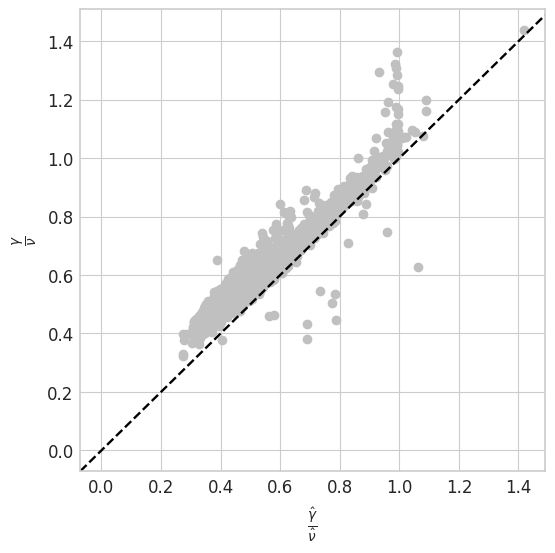

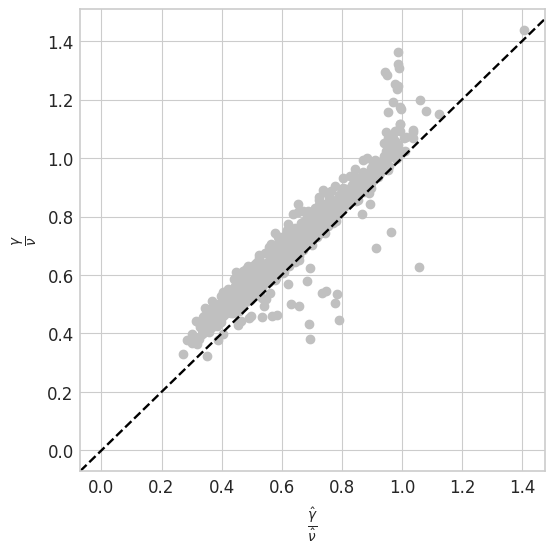

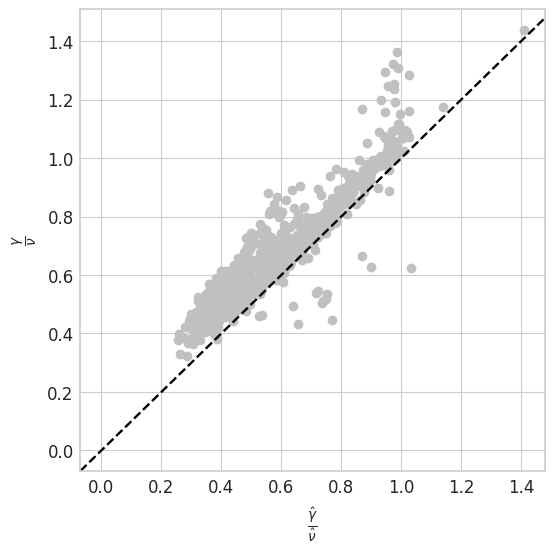

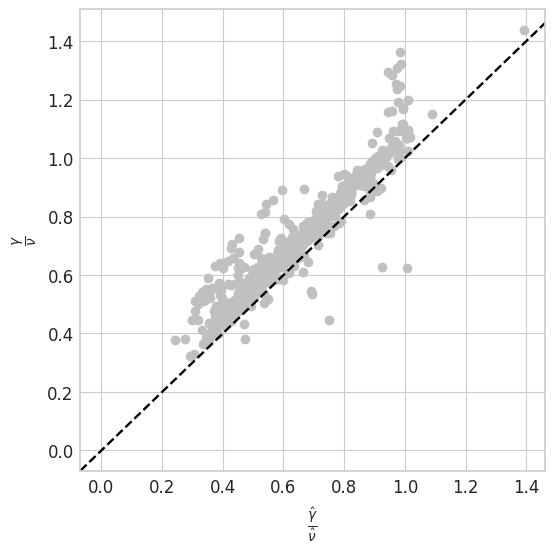

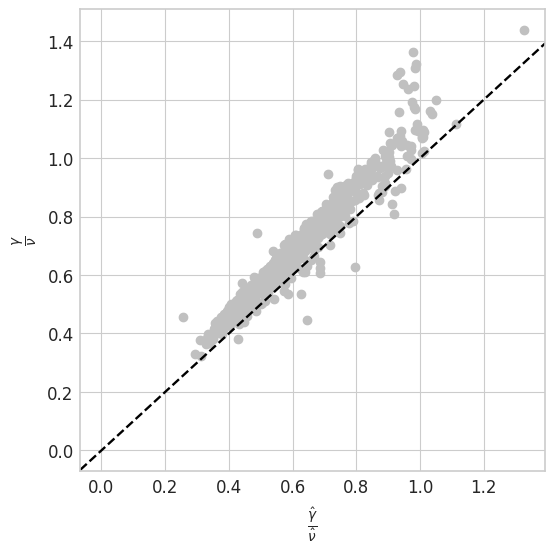

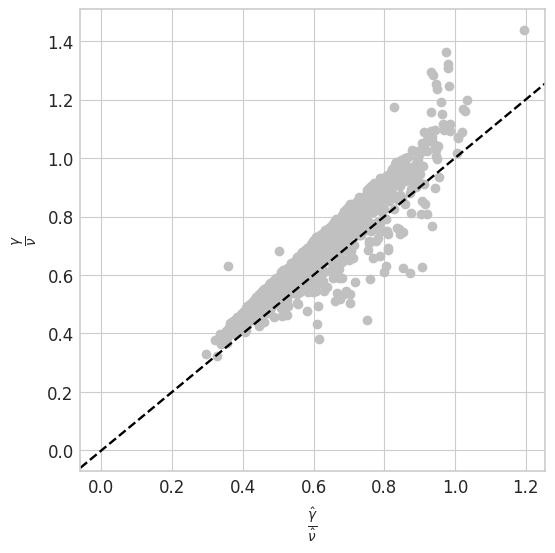

In [9]:
for noise, adata in zip(noise_levels, adatas):
    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.axline((0, 0), slope=1, color="black", linestyle="--")

        ax.set_xlabel(r"$\frac{\hat{\gamma}}{\hat{\nu}}$")
        ax.set_ylabel(r"$\frac{\gamma}{\nu}$")

        ax.scatter(
            y=adata.var["true_ratio_gamma_nu"],
            x=adata.var["vi_ratio_gamma_nu"],
            c="silver",
        )
        plt.show()

    if SAVE_FIGURES:
        path = FIG_DIR / "data_simulation" / "rate_parameter_ratios"
        path.mkdir(parents=True, exist_ok=True)
        fig.savefig(
            path / f"ratio_gamma_nu_noise_level_{noise}.svg", format="svg", transparent=True, bbox_inches="tight"
        )

#### Nuclear export/ splicing rate ratio

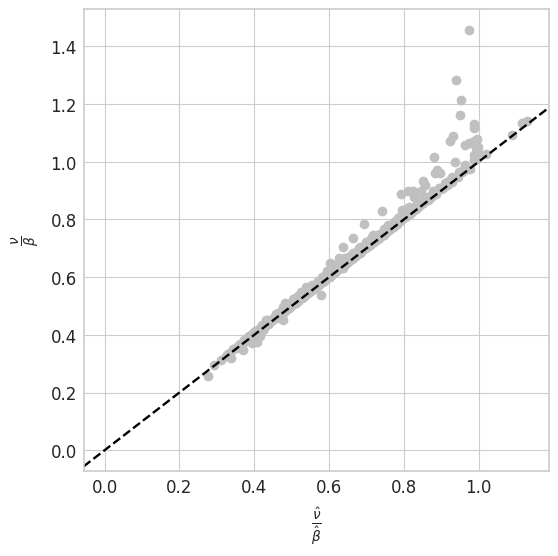

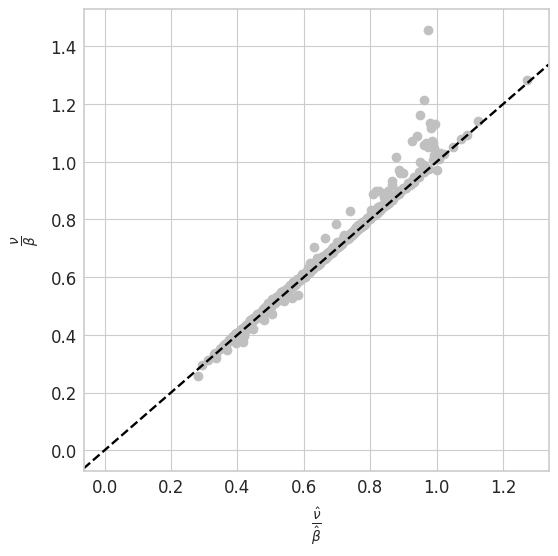

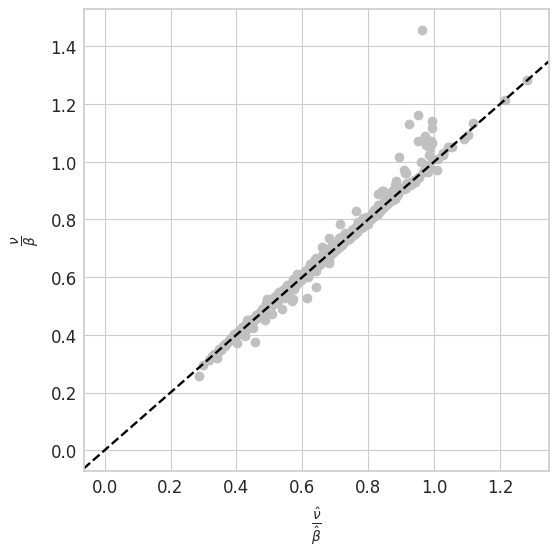

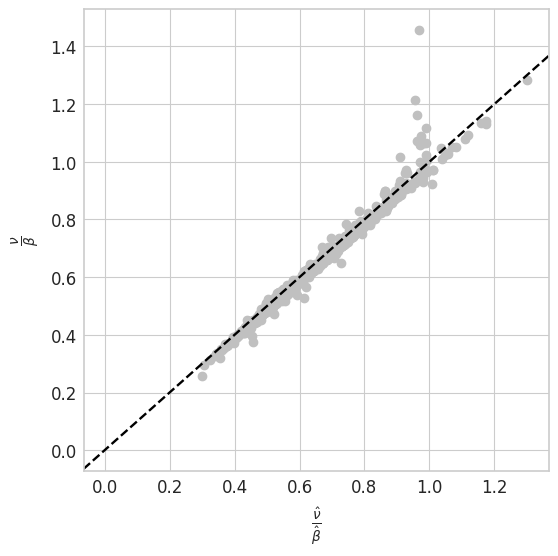

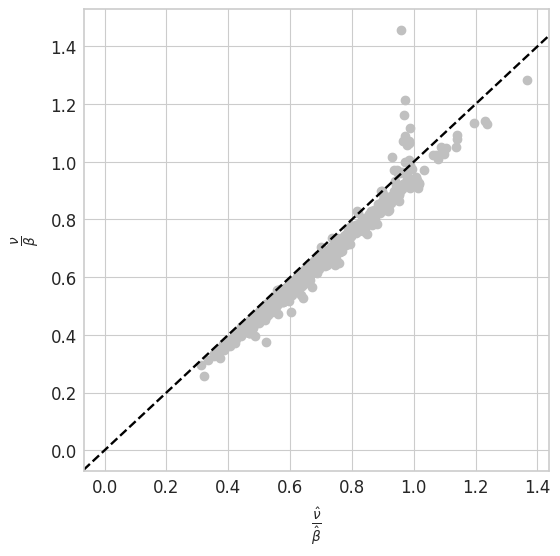

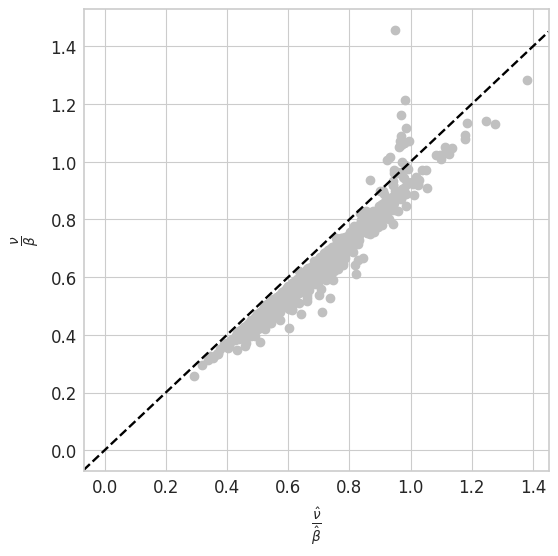

In [10]:
for noise, adata in zip(noise_levels, adatas):
    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.axline((0, 0), slope=1, color="black", linestyle="--")

        ax.set_xlabel(r"$\frac{\hat{\nu}}{\hat{\beta}}$")
        ax.set_ylabel(r"$\frac{\nu}{\beta}$")

        ax.scatter(
            y=adata.var["true_ratio_nu_beta"],
            x=adata.var["vi_ratio_nu_beta"],
            c="silver",
        )
        plt.show()

    if SAVE_FIGURES:
        path = FIG_DIR / "data_simulation" / "rate_parameter_ratios"
        path.mkdir(parents=True, exist_ok=True)
        fig.savefig(
            path / f"ratio_nu_beta_noise_level_{noise}.svg", format="svg", transparent=True, bbox_inches="tight"
        )

#### Degradation/ splicing rate ratio

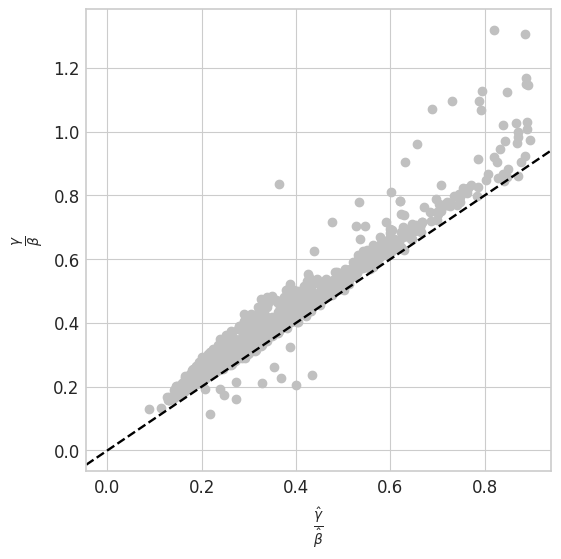

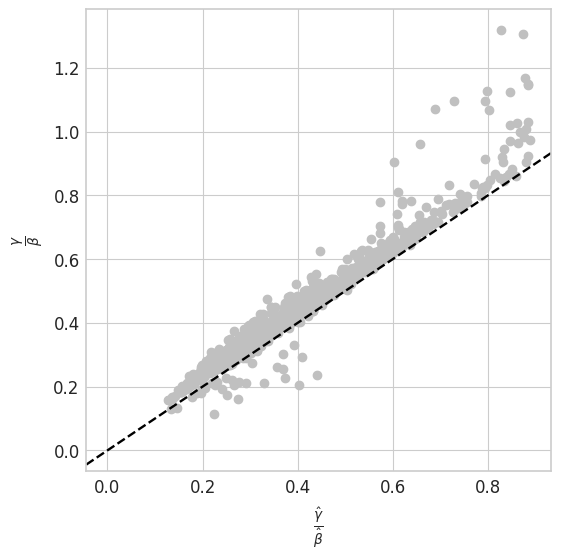

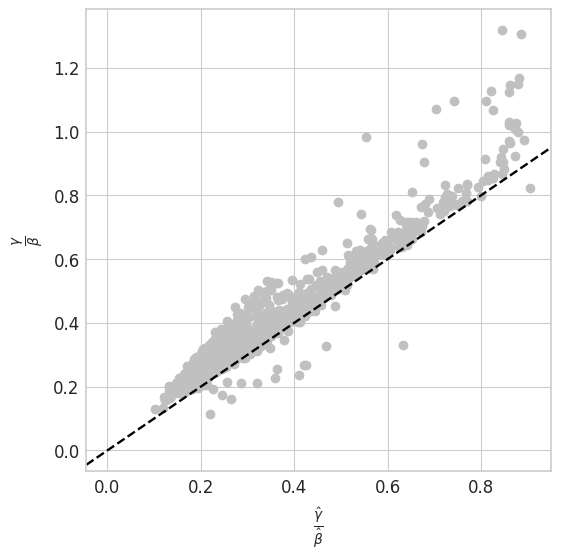

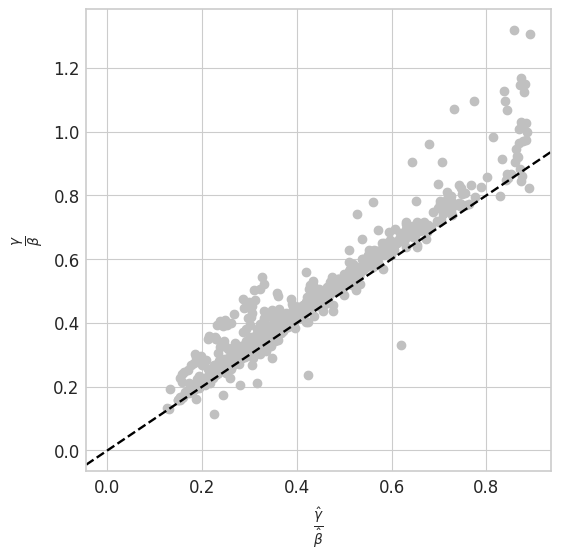

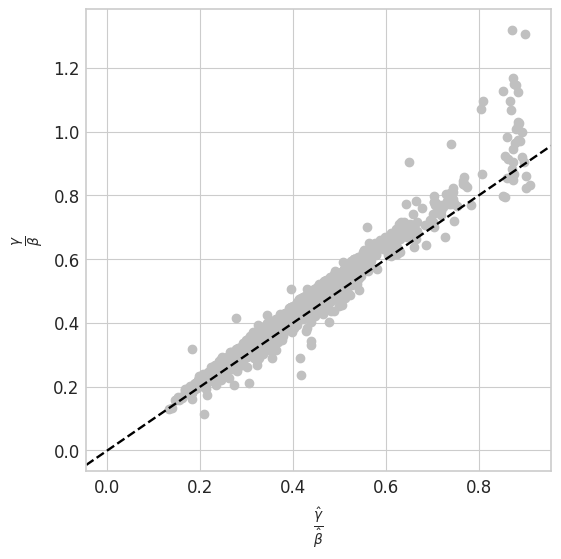

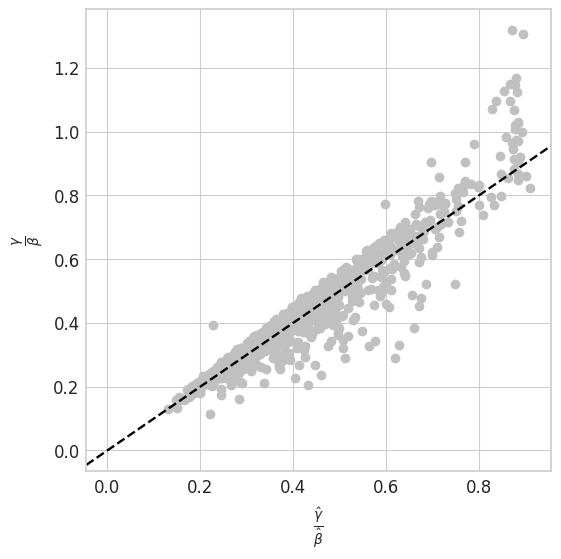

In [11]:
for noise, adata in zip(noise_levels, adatas):
    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.axline((0, 0), slope=1, color="black", linestyle="--")

        ax.set_xlabel(r"$\frac{\hat{\gamma}}{\hat{\beta}}$")
        ax.set_ylabel(r"$\frac{\gamma}{\beta}$")

        ax.scatter(
            y=adata.var["true_ratio_gamma_beta"],
            x=adata.var["vi_ratio_gamma_beta"],
            c="silver",
        )
        plt.show()

    if SAVE_FIGURES:
        path = FIG_DIR / "data_simulation" / "rate_parameter_ratios"
        path.mkdir(parents=True, exist_ok=True)
        fig.savefig(
            path / f"ratio_gamma_beta_noise_level_{noise}.svg", format="svg", transparent=True, bbox_inches="tight"
        )

#### Transcription/ splicing rate ratio

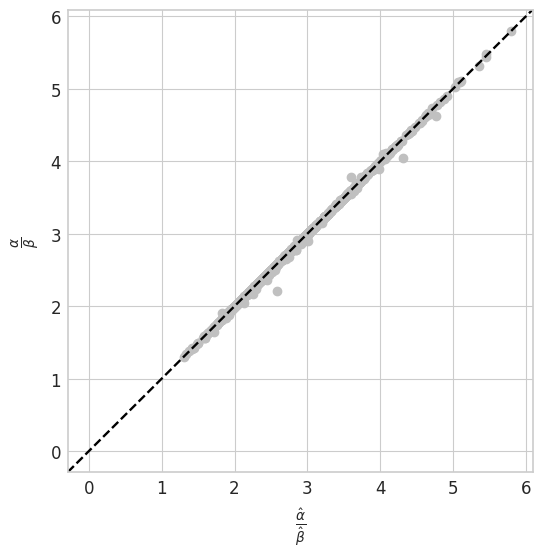

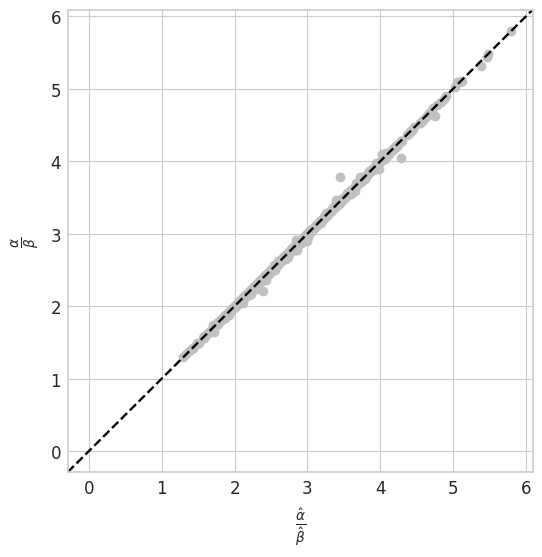

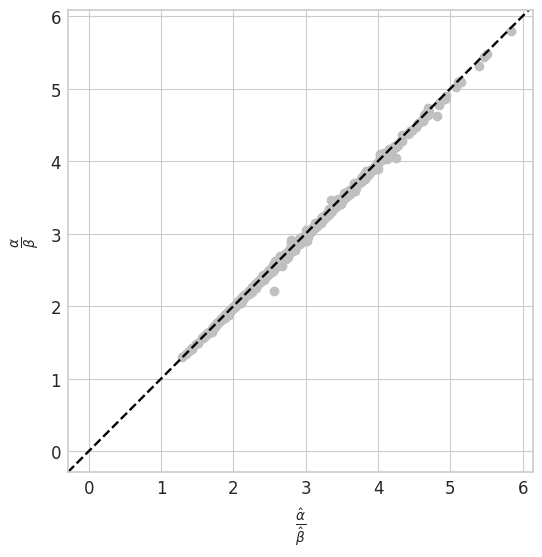

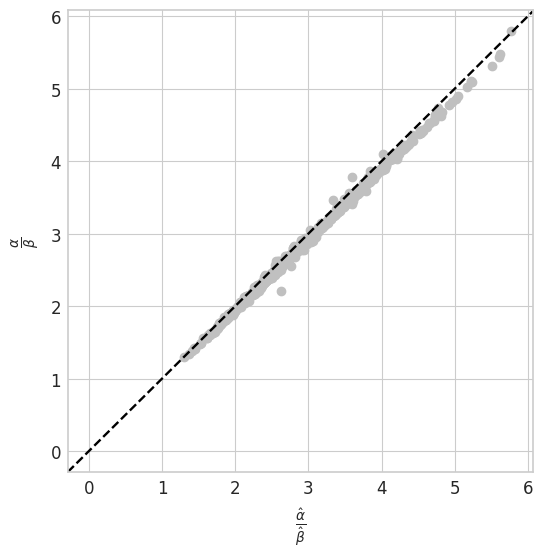

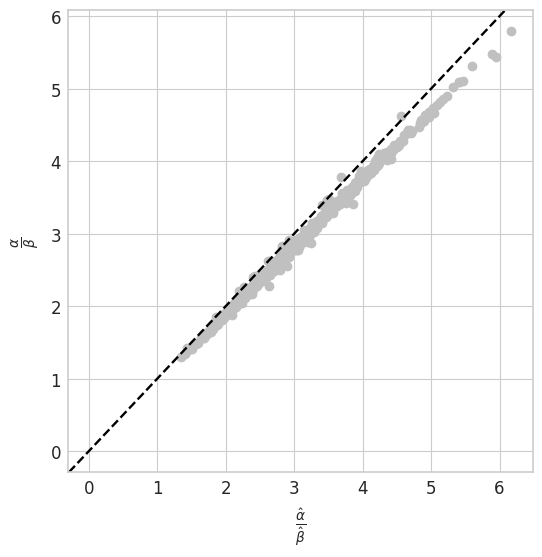

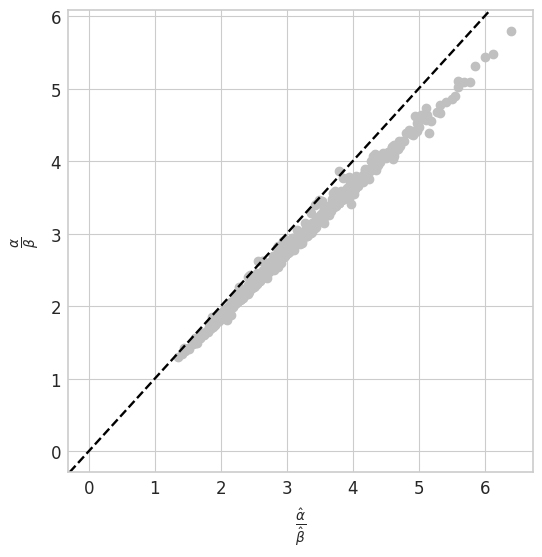

In [12]:
for noise, adata in zip(noise_levels, adatas):
    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.axline((0, 0), slope=1, color="black", linestyle="--")

        ax.set_xlabel(r"$\frac{\hat{\alpha}}{\hat{\beta}}$")
        ax.set_ylabel(r"$\frac{\alpha}{\beta}$")

        ax.scatter(
            y=adata.var["true_ratio_alpha_beta"],
            x=adata.var["vi_ratio_alpha_beta"],
            c="silver",
        )
        plt.show()

    if SAVE_FIGURES:
        path = FIG_DIR / "data_simulation" / "rate_parameter_ratios"
        path.mkdir(parents=True, exist_ok=True)
        fig.savefig(
            path / f"ratio_alpha_beta_noise_level_{noise}.svg", format="svg", transparent=True, bbox_inches="tight"
        )

#### Transcription/ nuclear export rate ratio

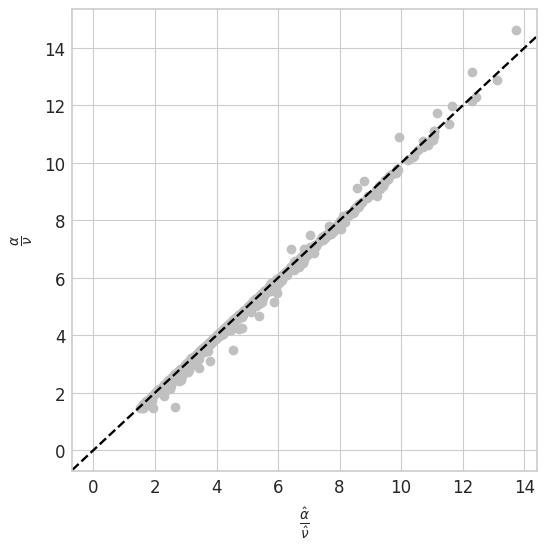

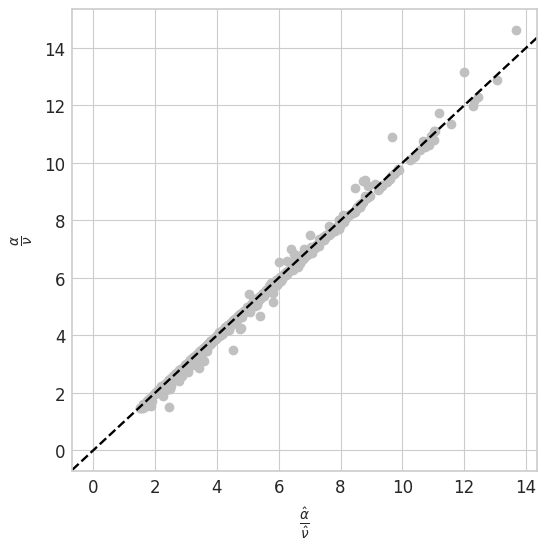

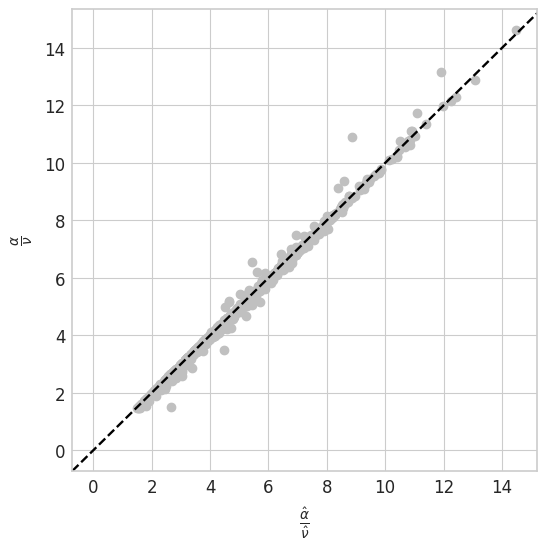

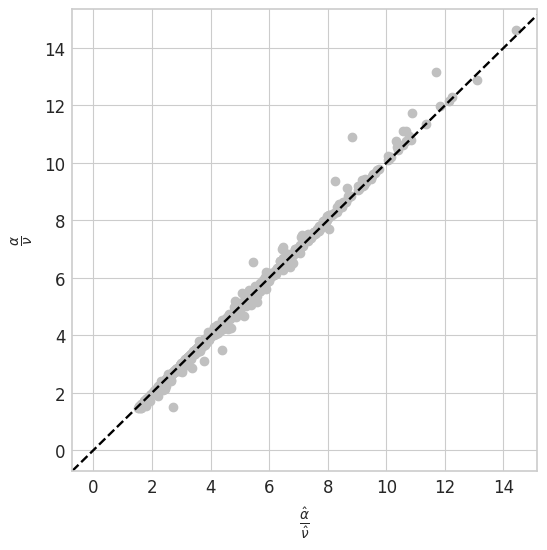

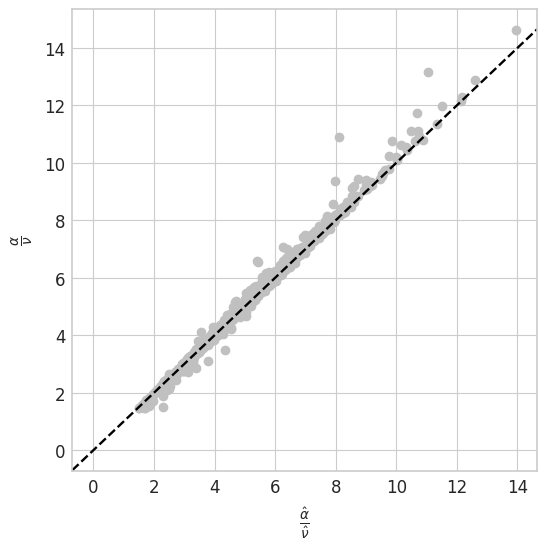

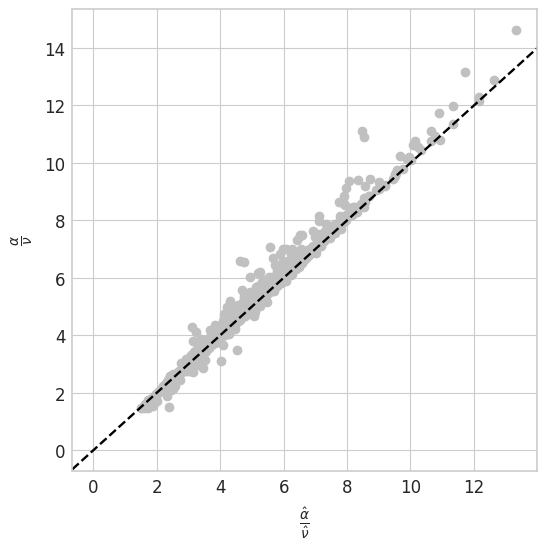

In [13]:
for noise, adata in zip(noise_levels, adatas):
    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.axline((0, 0), slope=1, color="black", linestyle="--")

        ax.set_xlabel(r"$\frac{\hat{\alpha}}{\hat{\nu}}$")
        ax.set_ylabel(r"$\frac{\alpha}{\nu}$")

        ax.scatter(
            y=adata.var["true_ratio_alpha_nu"],
            x=adata.var["vi_ratio_alpha_nu"],
            c="silver",
        )
        plt.show()

    if SAVE_FIGURES:
        path = FIG_DIR / "data_simulation" / "rate_parameter_ratios"
        path.mkdir(parents=True, exist_ok=True)
        fig.savefig(
            path / f"ratio_alpha_nu_noise_level_{noise}.svg", format="svg", transparent=True, bbox_inches="tight"
        )

#### Transcription/ degradation rate ratio


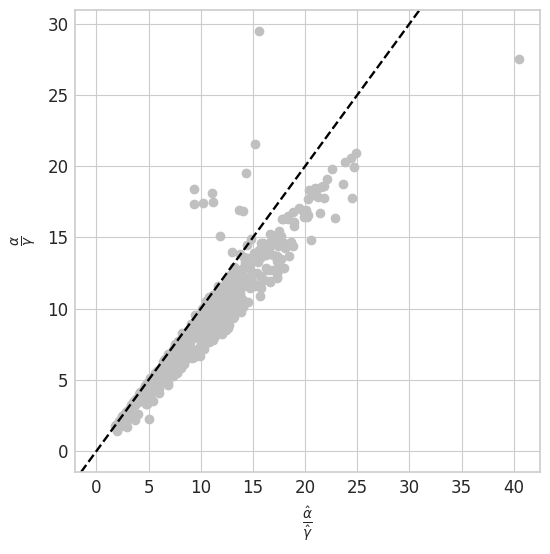

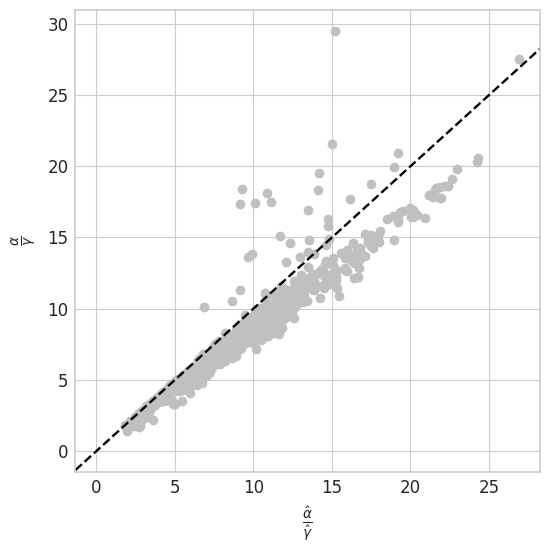

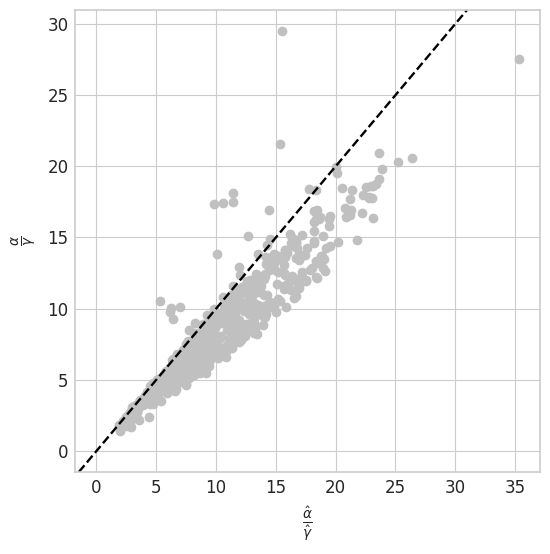

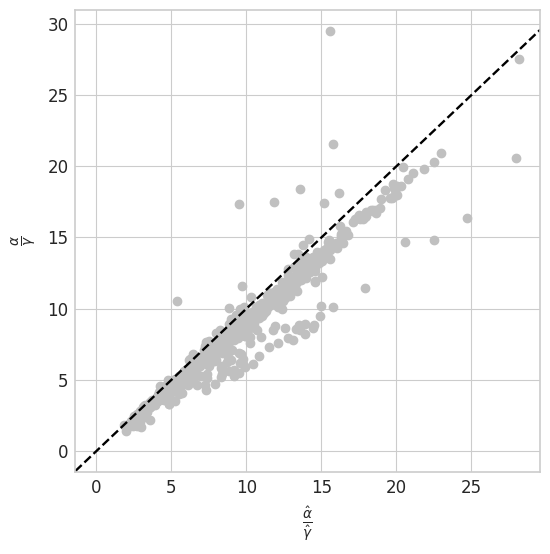

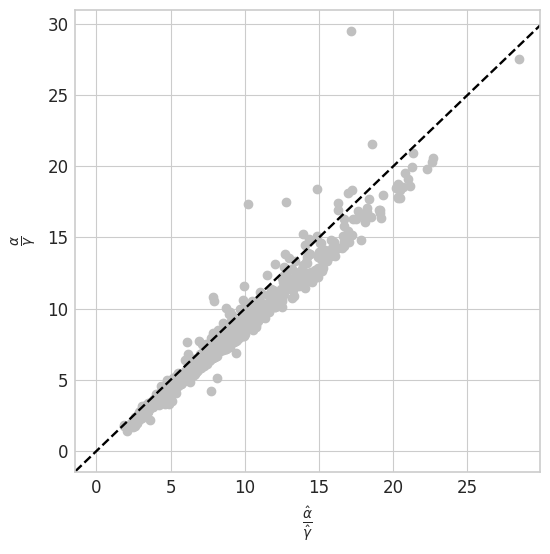

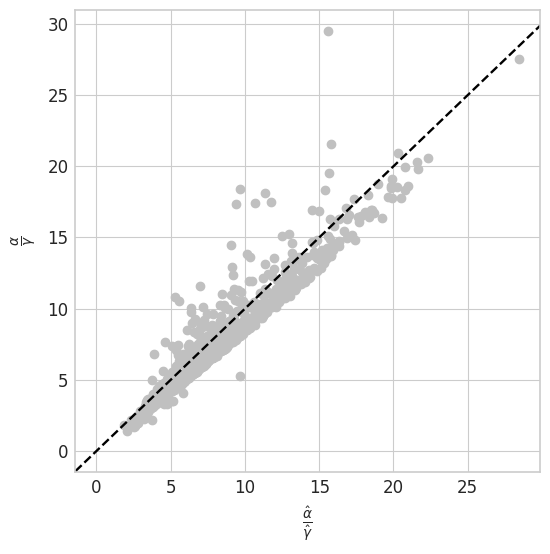

In [14]:
for noise, adata in zip(noise_levels, adatas):
    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.axline((0, 0), slope=1, color="black", linestyle="--")

        ax.set_xlabel(r"$\frac{\hat{\alpha}}{\hat{\gamma}}$")
        ax.set_ylabel(r"$\frac{\alpha}{\gamma}$")

        ax.scatter(
            y=adata.var["true_ratio_alpha_gamma"],
            x=adata.var["vi_ratio_alpha_gamma"],
            c="silver",
        )
        plt.show()

    if SAVE_FIGURES:
        path = FIG_DIR / "data_simulation" / "rate_parameter_ratios"
        path.mkdir(parents=True, exist_ok=True)
        fig.savefig(
            path / f"ratio_alpha_gamma_noise_level_{noise}.svg", format="svg", transparent=True, bbox_inches="tight"
        )

### Plot all rate parameter ratios, where on x axis all inferred ratios are stacked together and on y axis all true ratios are stacked together

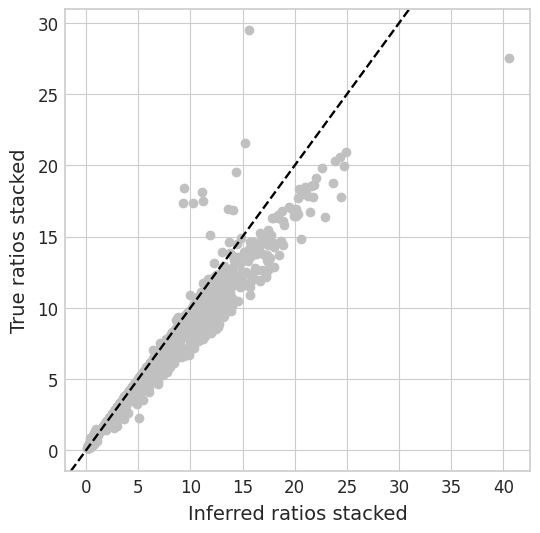

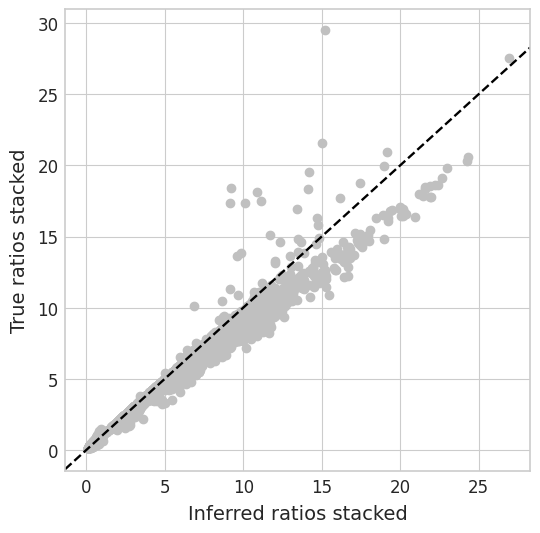

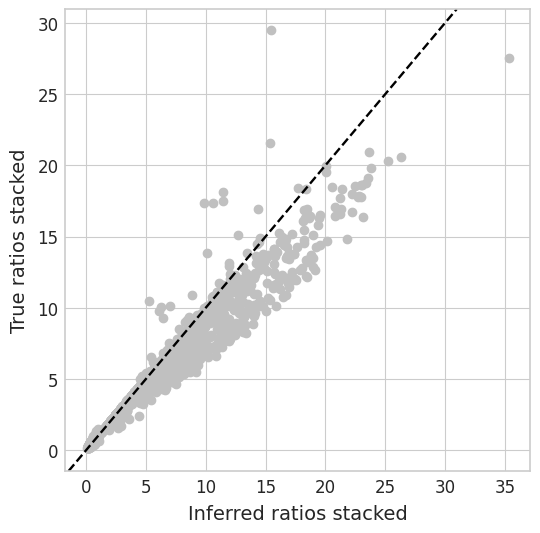

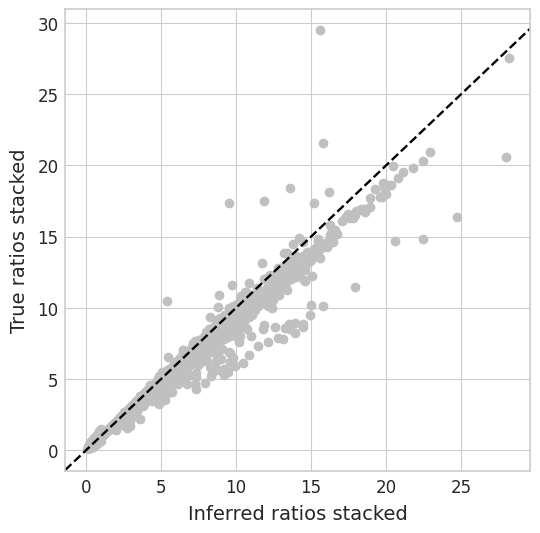

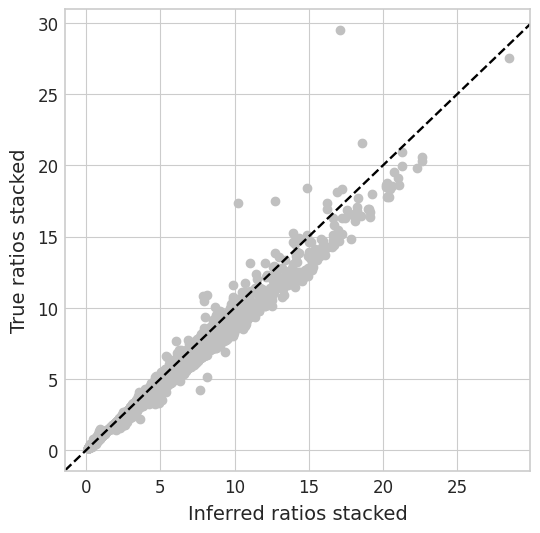

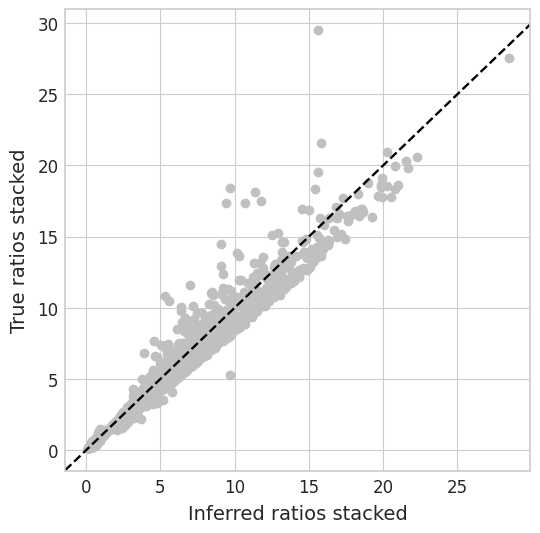

In [18]:
for noise, adata in zip(noise_levels, adatas):
    # get vars of vi and true to stack them together for plot
    vi_ratio_vars = []
    true_ratio_vars = []
    for var in adata.var.columns:
        if var.startswith("vi_ratio"):
            true_ratio_var = "true_ratio" + var.split("vi_ratio")[1]
            vi_ratio_vars.append(var)
            true_ratio_vars.append(true_ratio_var)

    y = np.concatenate([adata.var[true_ratios] for true_ratios in true_ratio_vars])
    x = np.concatenate([adata.var[vi_ratios] for vi_ratios in vi_ratio_vars])

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.axline((0, 0), slope=1, color="black", linestyle="--")

        ax.set_xlabel("Inferred ratios stacked")
        ax.set_ylabel("True ratios stacked")

        ax.scatter(
            y=y,
            x=x,
            c="silver",
        )
        plt.show()

    if SAVE_FIGURES:
        path = FIG_DIR / "data_simulation" / "rate_parameter_ratios"
        path.mkdir(parents=True, exist_ok=True)
        fig.savefig(
            path / f"all_ratios_stacked_noise_level_{noise}.svg", format="svg", transparent=True, bbox_inches="tight"
        )

## Compare MSEs of different models

In [19]:
mse_dfs = pd.DataFrame(columns=["MSE", "Feature", "Dataset"])
for adata, vae, noise in zip(adatas, vaes, noise_levels):
    mse_df_s_cyt = pd.DataFrame(columns=["MSE", "Feature", "Dataset"])
    mse_df_s_nuc = pd.DataFrame(columns=["MSE", "Feature", "Dataset"])
    mse_df_u_nuc = pd.DataFrame(columns=["MSE", "Feature", "Dataset"])

    # first we will get model's fit to also get MSE loss
    fits_s_cyt, fits_s_nuc, fits_u_nuc = vae.get_expression_fit(n_samples=20, return_numpy=True)

    mse_df_s_cyt["MSE"] = np.mean((fits_s_cyt - adata.layers["spliced_cytosol"]) ** 2, axis=0)
    mse_df_s_cyt["Feature"] = "Spliced cytosol"

    mse_df_s_nuc["MSE"] = np.mean((fits_s_nuc - adata.layers["spliced_nucleus"]) ** 2, axis=0)
    mse_df_s_nuc["Feature"] = "Spliced nucleus"

    mse_df_u_nuc["MSE"] = np.mean((fits_u_nuc - adata.layers["unspliced_nucleus"]) ** 2, axis=0)
    mse_df_u_nuc["Feature"] = "Unspliced nucleus"

    mse_df = pd.concat([mse_df_s_cyt, mse_df_s_nuc, mse_df_u_nuc])
    mse_df["Dataset"] = f"Noise Level: {noise}"

    mse_dfs = pd.concat([mse_dfs, mse_df])

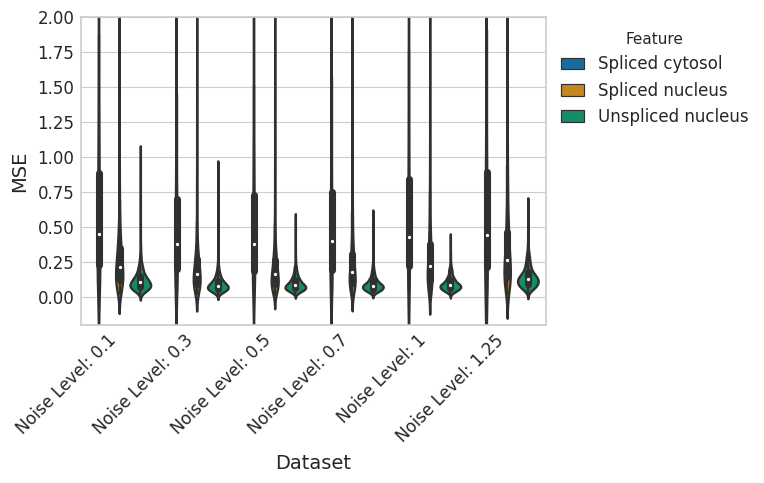

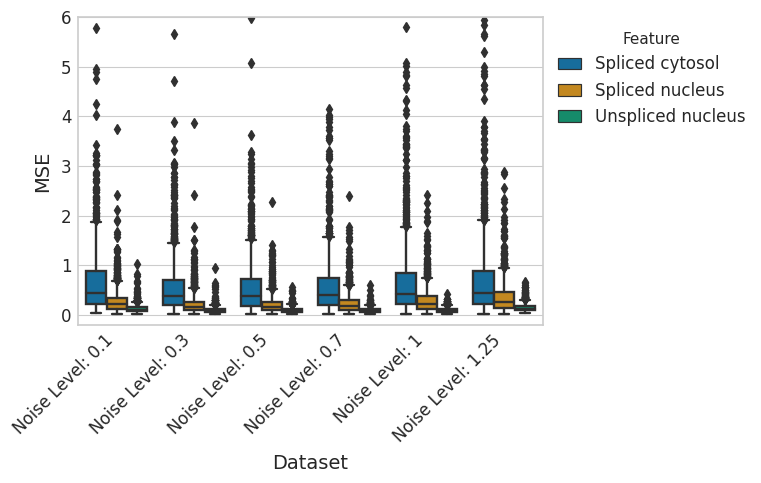

In [20]:
# Violinplot
with mplscience.style_context():
    sns.set_style(style="whitegrid")

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.violinplot(
        data=mse_dfs,
        orient="v",
        ax=ax,
        x="Dataset",
        y="MSE",
        hue="Feature",
        palette=sns.color_palette("colorblind").as_hex()[:3],
    )
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45, ha="right")
    ax.set_ylim([-0.2, 2])
    plt.show()

    if SAVE_FIGURES:
        path = FIG_DIR / "data_simulation" / "mse_comparison"
        path.mkdir(parents=True, exist_ok=True)
        fig.savefig(path / "mse_compare_noise_levels_violin.svg", format="svg", transparent=True, bbox_inches="tight")

# Boxplot
with mplscience.style_context():
    sns.set_style(style="whitegrid")

    fig, ax = plt.subplots(figsize=(6, 4))

    sns.boxplot(
        data=mse_dfs,
        x="Dataset",
        y="MSE",
        hue="Feature",
        palette=sns.color_palette("colorblind").as_hex()[:3],
    )
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45, ha="right")
    ax.set_ylim([-0.2, 6])
    plt.show()

    if SAVE_FIGURES:
        path = FIG_DIR / "data_simulation" / "mse_comparison"
        path.mkdir(parents=True, exist_ok=True)
        fig.savefig(path / "mse_compare_noise_levels_boxplot.svg", format="svg", transparent=True, bbox_inches="tight")

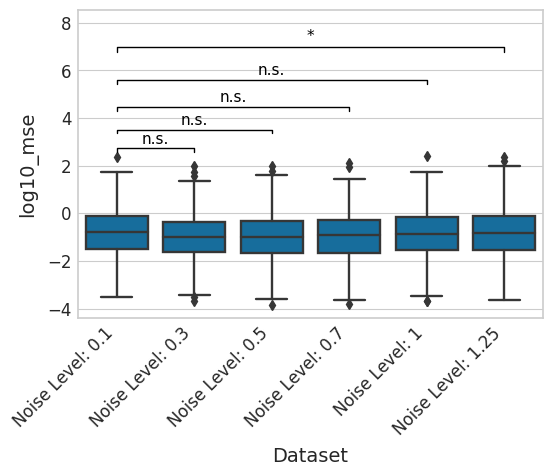

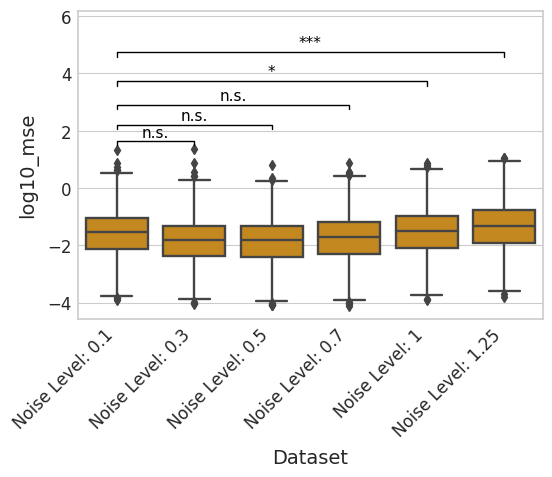

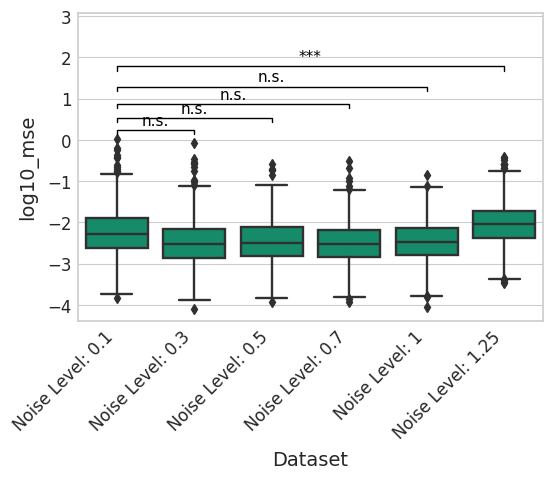

In [61]:
mse_dfs["log10_mse"] = np.log(mse_dfs["MSE"])

for idx, feature in enumerate(["Spliced cytosol", "Spliced nucleus", "Unspliced nucleus"]):
    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.boxplot(
            data=mse_dfs[mse_dfs.Feature == feature],
            x="Dataset",
            y="log10_mse",
            palette=[sns.color_palette("colorblind").as_hex()[idx]],  # sns.color_palette("colorblind").as_hex()[:6],
        )
        plt.xticks(rotation=45, ha="right")

        # Compare 0.1, 0.3
        ttest_res = ttest_ind(
            mse_dfs.loc[(mse_dfs.Feature == feature) & (mse_dfs.Dataset == "Noise Level: 0.1"), "MSE"],
            mse_dfs.loc[(mse_dfs.Feature == feature) & (mse_dfs.Dataset == "Noise Level: 0.3"), "MSE"],
            equal_var=False,
            alternative="less",
        )
        significance = _get_significance(ttest_res.pvalue)
        _add_significance(
            ax=ax,
            left=0,
            right=1,
            significance=significance,
            lw=1,
            bracket_level=1,
            c="k",
            level=0,
        )

        # Compare 0.1, 0.5
        ttest_res = ttest_ind(
            mse_dfs.loc[(mse_dfs.Feature == feature) & (mse_dfs.Dataset == "Noise Level: 0.1"), "MSE"],
            mse_dfs.loc[(mse_dfs.Feature == feature) & (mse_dfs.Dataset == "Noise Level: 0.5"), "MSE"],
            equal_var=False,
            alternative="less",
        )
        significance = _get_significance(ttest_res.pvalue)
        _add_significance(
            ax=ax,
            left=0,
            right=2,
            significance=significance,
            lw=1,
            bracket_level=1.15,
            c="k",
            level=0,
        )

        # Compare 0.1, 0.7
        ttest_res = ttest_ind(
            mse_dfs.loc[(mse_dfs.Feature == feature) & (mse_dfs.Dataset == "Noise Level: 0.1"), "MSE"],
            mse_dfs.loc[(mse_dfs.Feature == feature) & (mse_dfs.Dataset == "Noise Level: 0.7"), "MSE"],
            equal_var=False,
            alternative="less",
        )
        significance = _get_significance(ttest_res.pvalue)
        _add_significance(
            ax=ax,
            left=0,
            right=3,
            significance=significance,
            lw=1,
            bracket_level=1.15,
            c="k",
            level=0,
        )

        # Compare 0.1, 1
        ttest_res = ttest_ind(
            mse_dfs.loc[(mse_dfs.Feature == feature) & (mse_dfs.Dataset == "Noise Level: 0.1"), "MSE"],
            mse_dfs.loc[(mse_dfs.Feature == feature) & (mse_dfs.Dataset == "Noise Level: 1"), "MSE"],
            equal_var=False,
            alternative="less",
        )
        significance = _get_significance(ttest_res.pvalue)
        _add_significance(
            ax=ax,
            left=0,
            right=4,
            significance=significance,
            lw=1,
            bracket_level=1.15,
            c="k",
            level=0,
        )

        # Compare 0.1, 1.25
        ttest_res = ttest_ind(
            mse_dfs.loc[(mse_dfs.Feature == feature) & (mse_dfs.Dataset == "Noise Level: 0.1"), "MSE"],
            mse_dfs.loc[(mse_dfs.Feature == feature) & (mse_dfs.Dataset == "Noise Level: 1.25"), "MSE"],
            equal_var=False,
            alternative="less",
        )
        significance = _get_significance(ttest_res.pvalue)
        _add_significance(
            ax=ax,
            left=0,
            right=5,
            significance=significance,
            lw=1,
            bracket_level=1.15,
            c="k",
            level=0,
        )

        y_min, y_max = ax.get_ylim()
        ax.set_ylim([y_min, y_max + 1])
        plt.show()

        if SAVE_FIGURES:
            path = FIG_DIR / "data_simulation" / "mse_comparison"
            path.mkdir(parents=True, exist_ok=True)
            fig.savefig(path / f"mse_noise_level_{feature}.svg", format="svg", transparent=True, bbox_inches="tight")

## Boxplot of Pearson correlations between true and inferred ratio pairs

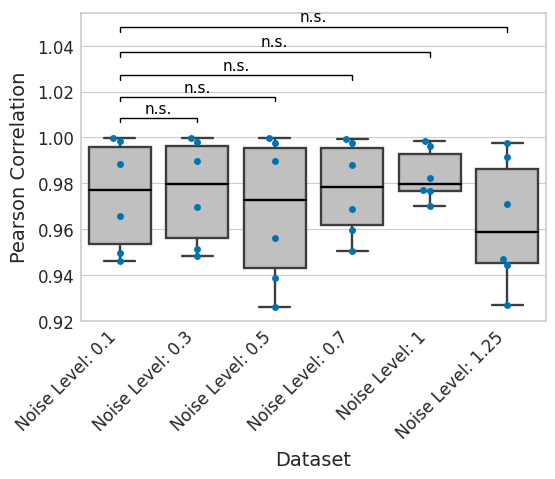

In [93]:
pearson_dfs = pd.DataFrame(columns=["Pearson Correlation", "Dataset"])
for adata, noise in zip(adatas, noise_levels):
    pearson_df = pd.DataFrame(columns=["Pearson Correlation", "Dataset"])
    # Calculate pearson statistics between all (vi_ratio_xy/ true_ratio_xy) tuples
    pearson_statistics = []
    for var in adata.var.columns:
        if var.startswith("vi_ratio"):
            true_ratio_var = "true_ratio" + var.split("vi_ratio")[1]
            pearson_statistic = pearsonr(adata.var[var], adata.var[true_ratio_var])
            pearson_statistics.append(pearson_statistic[0])
    pearson_df["Pearson Correlation"] = pearson_statistics
    pearson_df["Dataset"] = f"Noise Level: {noise}"

    pearson_dfs = pd.concat([pearson_dfs, pearson_df])


with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))

    sns.boxplot(
        data=pearson_dfs,
        x="Dataset",
        y="Pearson Correlation",
        boxprops={"facecolor": "silver"},
        medianprops={"color": "black"},
        # palette=sns.color_palette("colorblind").as_hex()[:5]
    )

    plt.xticks(rotation=45, ha="right")
    # Compare 0.1, 0.3
    ttest_res = ttest_ind(
        pearson_dfs.loc[(pearson_dfs.Dataset == "Noise Level: 0.1"), "Pearson Correlation"],
        pearson_dfs.loc[(pearson_dfs.Dataset == "Noise Level: 0.3"), "Pearson Correlation"],
        equal_var=False,
        alternative="greater",
    )
    significance = _get_significance(ttest_res.pvalue)
    _add_significance(
        ax=ax,
        left=0,
        right=1,
        significance=significance,
        lw=1,
        bracket_level=1.005,
        c="k",
        level=0,
    )

    # Compare 0.1, 0.5
    ttest_res = ttest_ind(
        pearson_dfs.loc[(pearson_dfs.Dataset == "Noise Level: 0.1"), "Pearson Correlation"],
        pearson_dfs.loc[(pearson_dfs.Dataset == "Noise Level: 0.5"), "Pearson Correlation"],
        equal_var=False,
        alternative="greater",
    )
    significance = _get_significance(ttest_res.pvalue)
    _add_significance(
        ax=ax,
        left=0,
        right=2,
        significance=significance,
        lw=1,
        bracket_level=1.005,
        c="k",
        level=0,
    )

    # Compare 0.1, 0.7
    ttest_res = ttest_ind(
        pearson_dfs.loc[(pearson_dfs.Dataset == "Noise Level: 0.1"), "Pearson Correlation"],
        pearson_dfs.loc[(pearson_dfs.Dataset == "Noise Level: 0.7"), "Pearson Correlation"],
        equal_var=False,
        alternative="greater",
    )
    significance = _get_significance(ttest_res.pvalue)
    _add_significance(
        ax=ax,
        left=0,
        right=3,
        significance=significance,
        lw=1,
        bracket_level=1.005,
        c="k",
        level=0,
    )

    # Compare 0.1, 1
    ttest_res = ttest_ind(
        pearson_dfs.loc[(pearson_dfs.Dataset == "Noise Level: 0.1"), "Pearson Correlation"],
        pearson_dfs.loc[(pearson_dfs.Dataset == "Noise Level: 1"), "Pearson Correlation"],
        equal_var=False,
        alternative="greater",
    )
    significance = _get_significance(ttest_res.pvalue)
    _add_significance(
        ax=ax,
        left=0,
        right=4,
        significance=significance,
        lw=1,
        bracket_level=1.005,
        c="k",
        level=0,
    )

    # Compare 0.1, 1.25
    ttest_res = ttest_ind(
        pearson_dfs.loc[(pearson_dfs.Dataset == "Noise Level: 0.1"), "Pearson Correlation"],
        pearson_dfs.loc[(pearson_dfs.Dataset == "Noise Level: 1.25"), "Pearson Correlation"],
        equal_var=False,
        alternative="greater",
    )
    significance = _get_significance(ttest_res.pvalue)
    _add_significance(
        ax=ax,
        left=0,
        right=5,
        significance=significance,
        lw=1,
        bracket_level=1.005,
        c="k",
        level=0,
    )

    sns.swarmplot(
        y=pearson_dfs["Pearson Correlation"],
        x=pearson_dfs["Dataset"],
        color=sns.color_palette("colorblind").as_hex()[0],
        size=5,
    )

    plt.show()

    if SAVE_FIGURES:
        path = FIG_DIR / "data_simulation" / "rate_parameter_ratios"
        path.mkdir(parents=True, exist_ok=True)
        fig.savefig(
            path / "pearson_correlation_rate_ratios_noise_comparison.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )

## Boxplot of Spearman Correlation of true vs. inferred time

In [ ]:
spearman_dfs = pd.DataFrame(columns=["Spearman Correlation", "Dataset"])
for adata, noise, vae in zip(adatas, noise_levels, vaes):
    # for data simulation we want to include rep_ss probability * t_ma
    adata.layers["fit_t"] = vae.get_latent_time_with_rep_ss(n_samples=25)
    spearman_df = pd.DataFrame(columns=["Spearman Correlation", "Dataset"])
    # Calculate pearson statistics between all (vi_ratio_xy/ true_ratio_xy) tuples
    spearman_statistics = []
    for var_id in range(adata.shape[1]):
        spearman_statistic = spearmanr(adata.layers["fit_t"][:, var_id], adata.obs["true_t"])
        spearman_statistics.append(spearman_statistic[0])
    spearman_df["Spearman Correlation"] = spearman_statistics
    spearman_df["Dataset"] = f"Noise Level: {noise}"

    spearman_dfs = pd.concat([spearman_dfs, spearman_df])

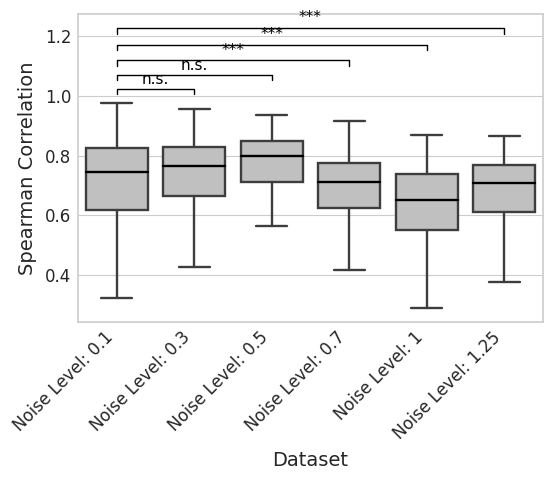

In [92]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))

    sns.boxplot(
        data=spearman_dfs,
        x="Dataset",
        y="Spearman Correlation",
        boxprops={"facecolor": "silver"},
        medianprops={"color": "black"},
    )

    plt.xticks(rotation=45, ha="right")

    # Compare 0.1, 0.3
    ttest_res = ttest_ind(
        spearman_dfs.loc[(spearman_dfs.Dataset == "Noise Level: 0.1"), "Spearman Correlation"],
        spearman_dfs.loc[(spearman_dfs.Dataset == "Noise Level: 0.3"), "Spearman Correlation"],
        equal_var=False,
        alternative="greater",
    )
    significance = _get_significance(ttest_res.pvalue)
    _add_significance(
        ax=ax,
        left=0,
        right=1,
        significance=significance,
        lw=1,
        bracket_level=1.01,
        c="k",
        level=0,
    )

    # Compare 0.1, 0.5
    ttest_res = ttest_ind(
        spearman_dfs.loc[(spearman_dfs.Dataset == "Noise Level: 0.1"), "Spearman Correlation"],
        spearman_dfs.loc[(spearman_dfs.Dataset == "Noise Level: 0.5"), "Spearman Correlation"],
        equal_var=False,
        alternative="greater",
    )
    significance = _get_significance(ttest_res.pvalue)
    _add_significance(
        ax=ax,
        left=0,
        right=2,
        significance=significance,
        lw=1,
        bracket_level=1.01,
        c="k",
        level=0,
    )

    # Compare 0.1, 0.7
    ttest_res = ttest_ind(
        spearman_dfs.loc[(spearman_dfs.Dataset == "Noise Level: 0.1"), "Spearman Correlation"],
        spearman_dfs.loc[(spearman_dfs.Dataset == "Noise Level: 0.7"), "Spearman Correlation"],
        equal_var=False,
        alternative="greater",
    )
    significance = _get_significance(ttest_res.pvalue)
    _add_significance(
        ax=ax,
        left=0,
        right=3,
        significance=significance,
        lw=1,
        bracket_level=1.01,
        c="k",
        level=0,
    )

    # Compare 0.1, 1
    ttest_res = ttest_ind(
        spearman_dfs.loc[(spearman_dfs.Dataset == "Noise Level: 0.1"), "Spearman Correlation"],
        spearman_dfs.loc[(spearman_dfs.Dataset == "Noise Level: 1"), "Spearman Correlation"],
        equal_var=False,
        alternative="greater",
    )
    significance = _get_significance(ttest_res.pvalue)
    _add_significance(
        ax=ax,
        left=0,
        right=4,
        significance=significance,
        lw=1,
        bracket_level=1.01,
        c="k",
        level=0,
    )

    # Compare 0.1, 1.25
    ttest_res = ttest_ind(
        spearman_dfs.loc[(spearman_dfs.Dataset == "Noise Level: 0.1"), "Spearman Correlation"],
        spearman_dfs.loc[(spearman_dfs.Dataset == "Noise Level: 1.25"), "Spearman Correlation"],
        equal_var=False,
        alternative="greater",
    )
    significance = _get_significance(ttest_res.pvalue)
    _add_significance(
        ax=ax,
        left=0,
        right=5,
        significance=significance,
        lw=1,
        bracket_level=1.01,
        c="k",
        level=0,
    )

    plt.show()

    if SAVE_FIGURES:
        path = FIG_DIR / "data_simulation" / "latent_time_correlations"
        path.mkdir(parents=True, exist_ok=True)
        fig.savefig(
            path / "spearman_latent_time_noise_level_comparison.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )

## Correlation of fitted switching time and true switching time

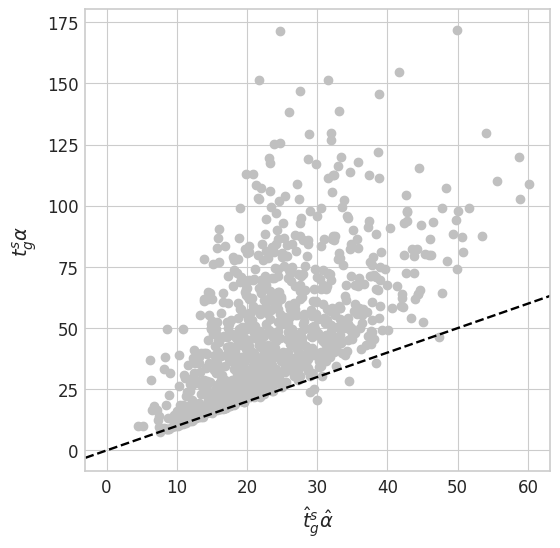

Spearman correlation of true and inferred switching times for noise level 0.1: SignificanceResult(statistic=0.6823171843457728, pvalue=5.527073095014558e-134) 



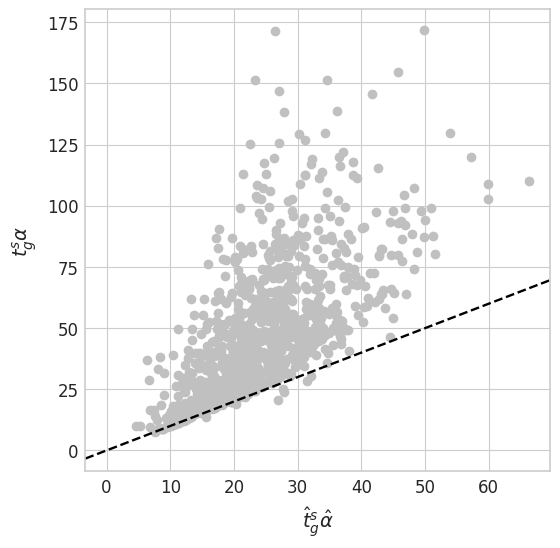

Spearman correlation of true and inferred switching times for noise level 0.3: SignificanceResult(statistic=0.7426263643890987, pvalue=6.596177582094793e-171) 



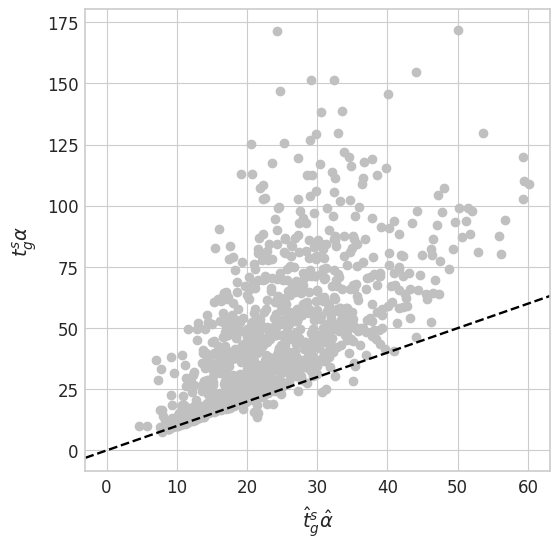

Spearman correlation of true and inferred switching times for noise level 0.5: SignificanceResult(statistic=0.7097644467985739, pvalue=1.3104254181529141e-149) 



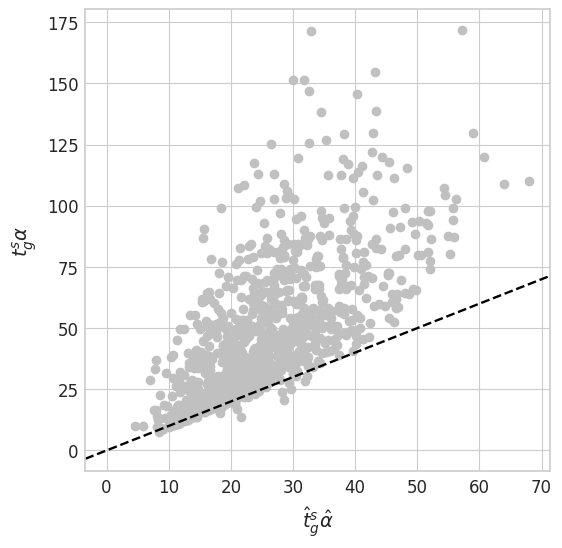

Spearman correlation of true and inferred switching times for noise level 0.7: SignificanceResult(statistic=0.7463028173398676, pvalue=1.7109996449482674e-173) 



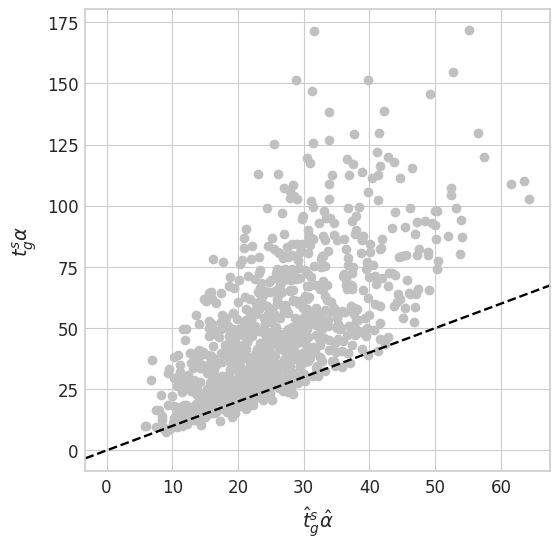

Spearman correlation of true and inferred switching times for noise level 1: SignificanceResult(statistic=0.729465980928143, pvalue=5.310644496025011e-162) 



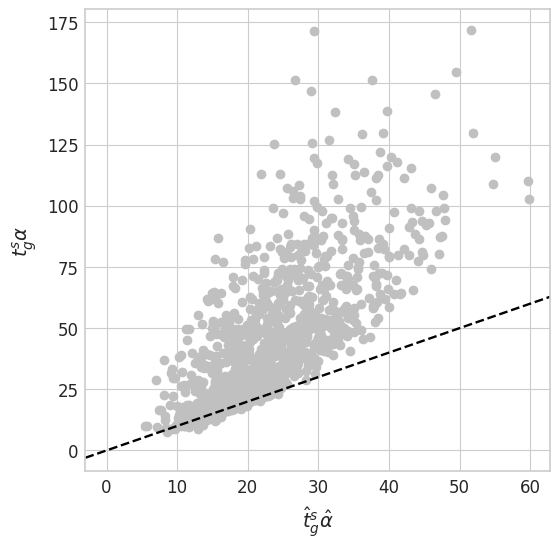

Spearman correlation of true and inferred switching times for noise level 1.25: SignificanceResult(statistic=0.7542870257972483, pvalue=2.8838054347764636e-179) 



In [89]:
for noise, adata in zip(noise_levels, adatas):
    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.axline((0, 0), slope=1, color="black", linestyle="--")

        ax.set_xlabel(r"$\hat{t}_g^s \hat{\alpha}$")
        ax.set_ylabel(r"$t_g^s \alpha$")

        ax.scatter(
            y=adata.var["true_t_"] * adata.var["true_transcription_rate"],
            x=adata.var["fit_t_"] * adata.var["fit_alpha"],
            c="silver",
        )
        plt.show()

    print(
        f"Spearman correlation of true and inferred switching times for noise level {noise}:",
        spearmanr(
            adata.var["true_t_"] * adata.var["true_transcription_rate"], adata.var["fit_t_"] * adata.var["fit_alpha"]
        ),
        "\n",
    )

    if SAVE_FIGURES:
        path = FIG_DIR / "data_simulation" / "latent_time_correlations"
        path.mkdir(parents=True, exist_ok=True)
        fig.savefig(
            path / f"ratio_true_time_switch_noise_level_{noise}.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )